## Predict moments for a previously unseen system


Import a structure and predict its moments using a previously-trained model

### Prelimary imports and settings 

In [1]:
# import basic scientific libraries
import numpy as np
import matplotlib.pyplot as plt


# import tensor flow, suppressing info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf


# import mlene module
import mlene


# set directories, descriptor and load trained network
model_dir='bestmodel/'     # location of trained network(s)
custom_dir='custom/'       # location of custom geometry files

desc = mlene.con_all_desc   # load model from paper
numzz, numcor, numac, desc_type, descriptor, model_name, desc_fn = desc
model = tf.keras.models.load_model(model_dir+descriptor+'.'+model_name+'_best.h5')


### Run the model on a new, unseen system

Import a geometry file and calculate its moment profile using a self-consistent calculation, neural networks, or both.  

There are three steps:
<br>

- Step 1: Load geometry and sublattice information only.   
An input file will be generated for use with the neural network.   
You can skip this step if you have already prepared a suitable input file.

<br>

- Step 2: Load a previously prepared input file with geometry, sublattice, classification and moment information. 

<br>

- Step 3: Predict moments using the ML model selected above.   
You can compare with self-consistent moments, analyse the energy levels, and export the ML moments for use elsewhere.



#### Step 1 - Prepare input file (skip if the .gz input file has been prepared beforehand)

See MLene-prep notebook.  
A previously prepared example is provided in Step 2 below

#### Step 2 -- Load the .gz input file

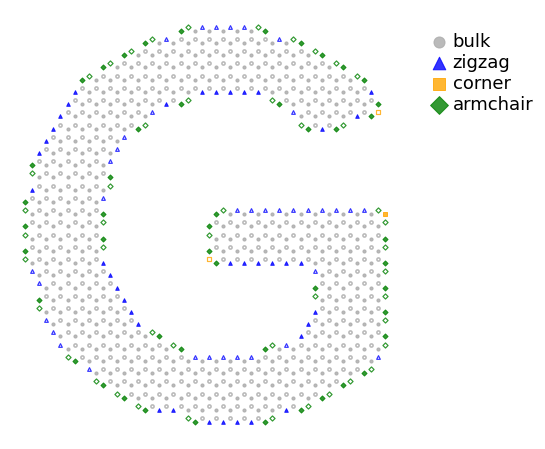

In [2]:
## Load suitable .gz input file from the 'custom' folder
## This should have x,y, sublattice, edgetype and moments in CSV format
## Dangling atoms should be removed in the previous step.
## Note the input moments can be zero -- the moments included here are only used to compare with ML predictions

## You can use the file generated in Step 1, or one prepared separately (uncomment the 'config_name= ' line).
## Some prepared examples in the download: 'ireland', 'mermaid', 'antidot'


config_name='g.dat.tidied'       # an example system, stored in the custom_dir directory

x1, y1, subs1, sysedges, final =  np.loadtxt(custom_dir+config_name+'.gz', unpack=True, delimiter=',')
fig, ax = mlene.map_site_types(x1, y1, subs1, sysedges)
plt.show()

#### Step 3

Create a descriptor for the system, and predict moments using the neural network, and save.

In [3]:
# create descriptor
site_desc = desc_fn (custom_dir+config_name+'.gz')

#predict moments
custom_predictions = model.predict(site_desc[:, :-3]).flatten()


## restrict output and analysis to a region of interest 
## this can be useful if you want to remove buffer regions in, e.g. ribbons.
## by default all sites are included 

start=0
stop = len(custom_predictions)

xn=x1[start:stop]
yn=y1[start:stop]
subn = subs1[start:stop]
predmom = custom_predictions[start:stop]
actmom = final[start:stop]

# Save the predicted moment profile (with sublattice dependent sign) to a file
np.savetxt(custom_dir+config_name+'.prediction', np.c_[xn, yn, subn*predmom] ,delimiter=',')

Map the predicted moments, and compare with SC values if provided:

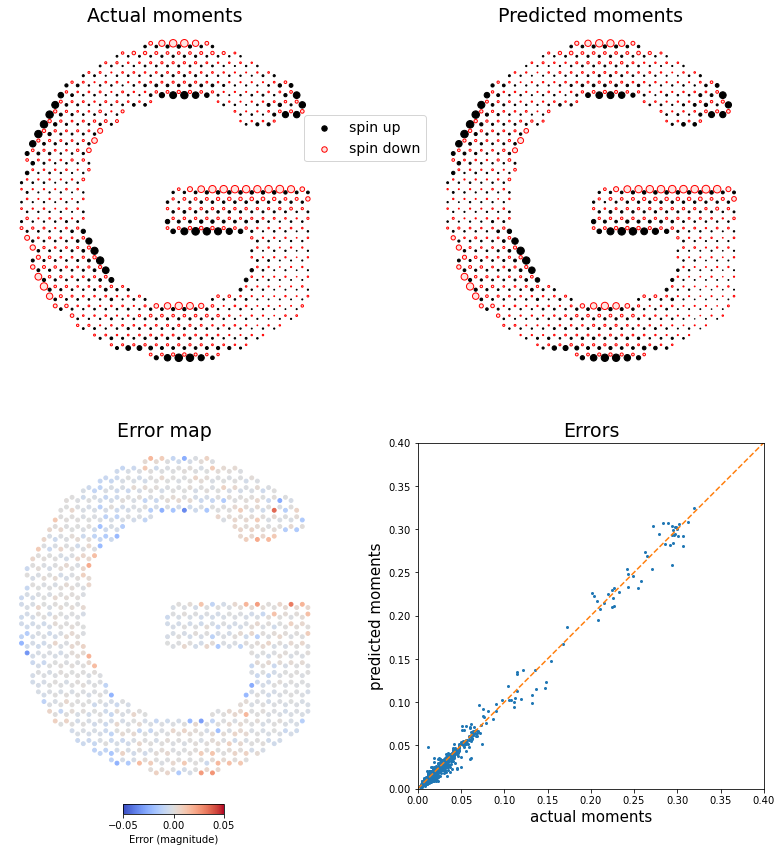

In [4]:
#control the overall size of dots by changing the value of 'factor'

factor = 60

if (np.any(final!=0.0)):
    fig, ax = mlene.compare_SC_ML (xn, yn, subn, actmom, predmom, dotsize=factor, figsize=14)

else:
    renorm = factor/max(abs(predmom))

    fig=plt.figure(figsize=(20,20))
    
    ax = fig.add_subplot(111)
    

    #ax.set_title('Predicted moments', fontsize=15)
    ax.scatter(xn[subn==1], yn[subn==1], s=renorm*abs(predmom)[subn==1], color='black')
    ax.scatter(xn[subn==-1], yn[subn==-1], s=renorm*abs(predmom)[subn==-1], edgecolors='red', facecolors='mistyrose')
    ax.axis('off')
    ax.set_aspect('equal')
    fig.patch.set_facecolor('white')
plt.show()

Compare the energy levels of the system with the different moment evaluations:   
(This performs a direct inversion of the Hamiltonian matrix, and will be slow for very large systems)

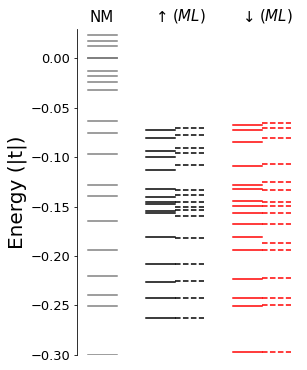

In [5]:
fig, ax = mlene.compare_levels (xn, yn, subn, actmom, predmom, -0.3, 0.03)
plt.show()